In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])


irf = {"ff_ex": None, "ff_in": None, "fb_ex": None, "fb_in": None}

## Feedforward excitation

In [2]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                 A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                 w_rg=w_rg, A_rg=A_rg, a_rg=a_rg)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)
irf["ff_ex"] = relay.irf[0, :, :]

positions = network.integrator.positions

## Feedforward inhibition

In [3]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                 A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                 w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                 w_rig=w_rig, A_rig=A_rig, a_rig=a_rig)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)
irf["ff_in"] = relay.irf[0, :, :]

## Feedback inhibition

In [4]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                         A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                         w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                         w_rc_ex=w_rc_ex, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)
irf["fb_ex"] = relay.irf[0, :, :]

## Feedback excitation

In [5]:
network = create_spatial_network(nt=nt, nr=nr, dt=dt, dr=dr,
                         A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                         w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                         w_rc_in=w_rc_in, A_rc_in=A_rc_in, a_rc_in=a_rc_in)

[relay] = get_neuron("Relay", network)
network.compute_irf(relay)
irf["fb_in"] = relay.irf[0, :, :]

## Plotting

### Setting:

In [6]:
x_id = 52
vmax = 0.25
vmin = -0.07

Nr = network.integrator.Nr
x_m = int(Nr/2-x_id)
x_p = int(Nr/2+x_id)

cmap = "RdBu_r"
interpolation = "none"


fig = plt.figure(figsize=(9, 5.5))
gs1 = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[1, 0])
ax3 = plt.subplot(gs1[:, 1:])

plt.close()

### Spatial receptive field (2d):

In [7]:
extent = [positions[x_m], positions[x_p], positions[x_m], positions[x_p]]

im = ax1.imshow(irf["ff_ex"][x_m:x_p, x_m:x_p],
                cmap=cmap, extent=extent, origin="lower", interpolation=interpolation, aspect="auto",
                vmin=vmin, vmax=vmax, norm=MidpointNormalize(midpoint=0.))

ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')

ax1.spines['left'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_color('none')

ax1.set_yticks([-2, 0, 2])
ax1.set_xticks([-2, 0, 2])

ax1.set_xlabel("$x$ (deg)")
ax1.set_ylabel("$y$ (deg)")

ax1.xaxis.set_label_position("top")
ax1.xaxis.tick_top()

ax1.grid(False)

### Illustrative figure 1d

In [8]:
ax2.plot(positions[x_m:x_p], irf["ff_ex"][x_m:x_p, int(Nr/2)])
ax2.set_xlabel("$x$ (deg)", x=1.1)

ax2.spines['left'].set_position(('data', 0))
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_position(('data', 0))

ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')

ax2.set_yticks([])
ax2.set_xticks([])

ax2.grid(False)

ax2.set_facecolor("w")
ax2.axhline(y=0, color='k', linewidth=1.)
ax2.axvline(x=0, color='k', linewidth=1.)

x_max = positions[int(Nr/2)+np.argmax(irf["ff_ex"][int(Nr/2):, int(Nr/2)])].magnitude
x_min = positions[int(Nr/2)+np.argmin(irf["ff_ex"][int(Nr/2):, int(Nr/2)])].magnitude

irf_max = irf["ff_ex"][int(Nr/2):, int(Nr/2)].max().magnitude
irf_min = irf["ff_ex"][int(Nr/2):, int(Nr/2)].min().magnitude

# center excitation
ax2.plot([0, x_max-1.5], [irf_max, irf_max], color='k', linewidth=1, linestyle=":")
ax2.annotate("Center \n excitation", xy=(x_max-2.5, irf_max/2), xycoords='data',
             xytext=(+1, 0), textcoords='offset points', rotation=270)
ax2.annotate("", xy=(x_max-1, 0), xycoords='data',
             xytext=(x_max-1, irf_max), textcoords='data',
             arrowprops={'arrowstyle': '<|-|>', 'linestyle': '-', 'linewidth': 1, 'color': 'k'})

# surround inhibition
ax2.plot([0, x_min+0.5], [irf_min, irf_min], color='k', linewidth=1, linestyle=":")
ax2.annotate("Surround \n inhibition", xy=(x_min-0.3, irf_min+0.1), xycoords='data',
             xytext=(+1, 0), textcoords='offset points')
ax2.annotate("", xy=(x_min, 0), xycoords='data',
             xytext=(x_min, irf_min), textcoords='data',
             arrowprops={'arrowstyle': '-', 'linestyle': '-', 'linewidth': 1, 'color': 'k'})

# size
ax2.plot([x_max-0.9, x_max-0.9], [0, irf_min-0.2], color='k', linewidth=1,
         linestyle=":")
ax2.annotate("Size", xy=(x_max-0.7, irf_min-0.17), xycoords='data',
             xytext=(0, 0), textcoords='offset points', rotation=270)
ax2.annotate("", xy=(x_max-0.9, irf_min-0.05), xycoords='data',
             xytext=(0, irf_min-0.05), textcoords='data',
             arrowprops={'arrowstyle': '<|-|>', 'linestyle': '-', 'linewidth': 1, 'color': 'k'})

### Spatial receptive field (1d):


In [9]:
ax3.plot(positions[x_m:x_p], irf["ff_ex"][x_m:x_p, int(Nr/2)], "--k", label="feedforward excitation")
ax3.plot(positions[x_m:x_p], irf["ff_in"][x_m:x_p, int(Nr/2)], label="feedforward inhibition")
ax3.plot(positions[x_m:x_p], irf["fb_in"][x_m:x_p, int(Nr/2)], label="feedback inhibition")
ax3.plot(positions[x_m:x_p], irf["fb_ex"][x_m:x_p, int(Nr/2)], label="feedback excitation")
    
    
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xlim([-2.6, 2.6])
ax3.set_xlabel("$x$ (deg)")
ax3.set_ylabel("Amplitude")

ax3.legend(fontsize=14, handlelength=0.5, labelspacing=0.4, borderpad=0.0, loc=2)

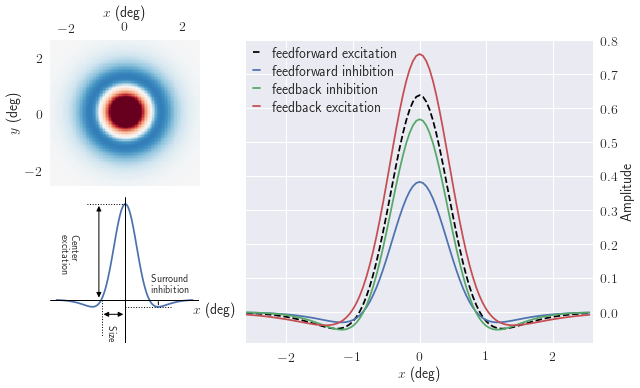

In [10]:
fig.tight_layout()
fig